In [145]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from openimages import OpenImageDataset

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [146]:
class InferenceConfig(Config):
    """
    """
    # Give the configuration a recognizable name
    NAME = "openimages"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 602  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    
inference_config = InferenceConfig()

In [155]:
# Recreate the model in inference mode
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

import tensorflow as tf

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", 
                              config=inference_config,
                              model_dir=MODEL_DIR)
  
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()
model_path = os.path.join(ROOT_DIR, 'logs/openimages20190926T0931/mask_rcnn_openimages_0011.h5')

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/bartosz/open-images/Mask_RCNN/logs/openimages20190926T0931/mask_rcnn_openimages_0011.h5
Re-starting from epoch 11


In [156]:
PATH = os.path.abspath(os.path.join(ROOT_DIR, '../data/'))

# Validation dataset
dataset_val = OpenImageDataset()
dataset_val.load_dataset(PATH, 'validation')
dataset_val.prepare()

In [168]:
image_id = random.choice(dataset_val.image_ids)
# image_id = 708
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

In [169]:
results = model.detect([original_image], verbose=1)

r = results[0]
print(r['rois'].shape[0])

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 614)              min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
1


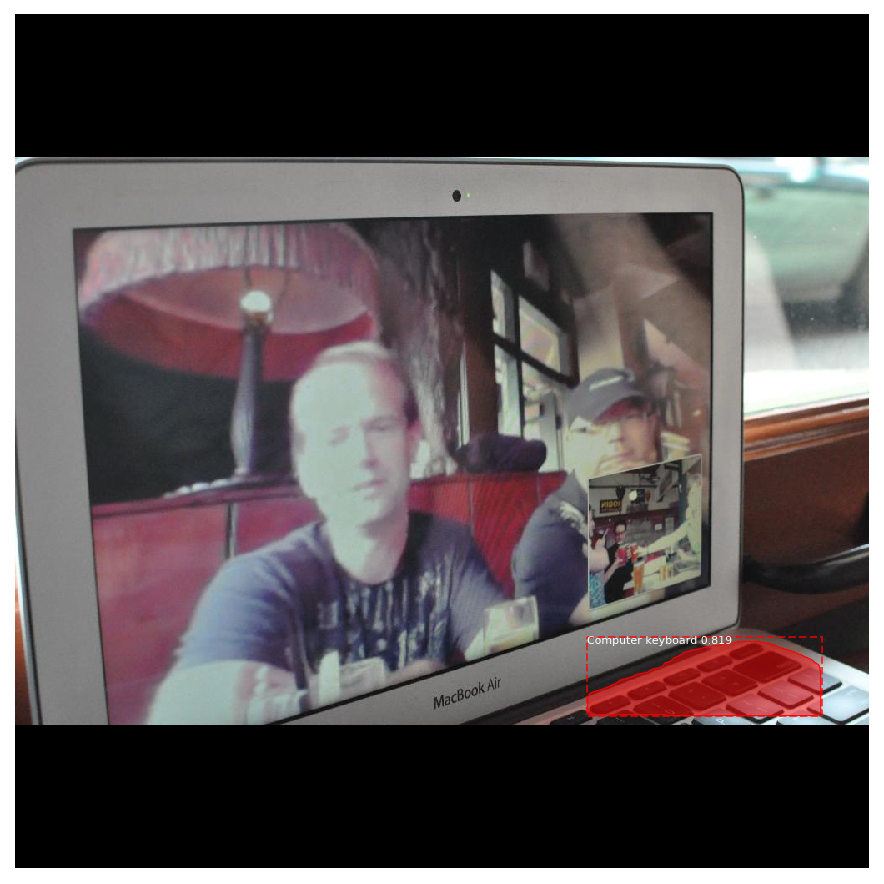

In [170]:
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

In [171]:
image_id

338

In [172]:
r

{'rois': array([[746, 686, 841, 968]], dtype=int32),
 'class_ids': array([94], dtype=int32),
 'scores': array([0.8192098], dtype=float32),
 'masks': array([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        ...,
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]])}

In [173]:
mask = r['masks'][:, :, 0]
bbox = r['rois'][0, :]

In [174]:
bbox

array([746, 686, 841, 968], dtype=int32)

In [175]:
image_size = dataset_val.image_info[image_id]['size']

In [176]:
nx, ny = image_size
new_nx, new_ny = 1024, 1024

In [177]:
ratio = nx / ny
if ratio < 1:
    crop_x = int((new_nx - ratio * new_ny)/2)
    cropped_mask = mask[crop_x:-crop_x, :]
    crop_bbox = [max(bbox[0] - crop_x, 0), bbox[1],
                 max(bbox[2] - crop_x, 0), bbox[3]]
    
else:
    crop_y = int((new_ny - new_nx / ratio)/2)
    cropped_mask = mask[:, crop_y:-crop_y]
    crop_bbox = [bbox[0], max(bbox[1] - crop_y, 0),
                 bbox[2], bbox[3] - crop_y]
    
true_mask = utils.resize(cropped_mask, image_size)
true_bbox = (np.array(crop_bbox) * image_size[0] / cropped_mask.shape[0]).astype(int)

In [178]:
true_mask.shape

(680, 1024)

In [179]:
import skimage

In [180]:
true_bbox

array([574, 686, 669, 968])

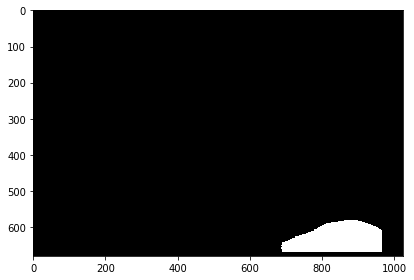

In [181]:
skimage.io.imshow(true_mask)

## show image

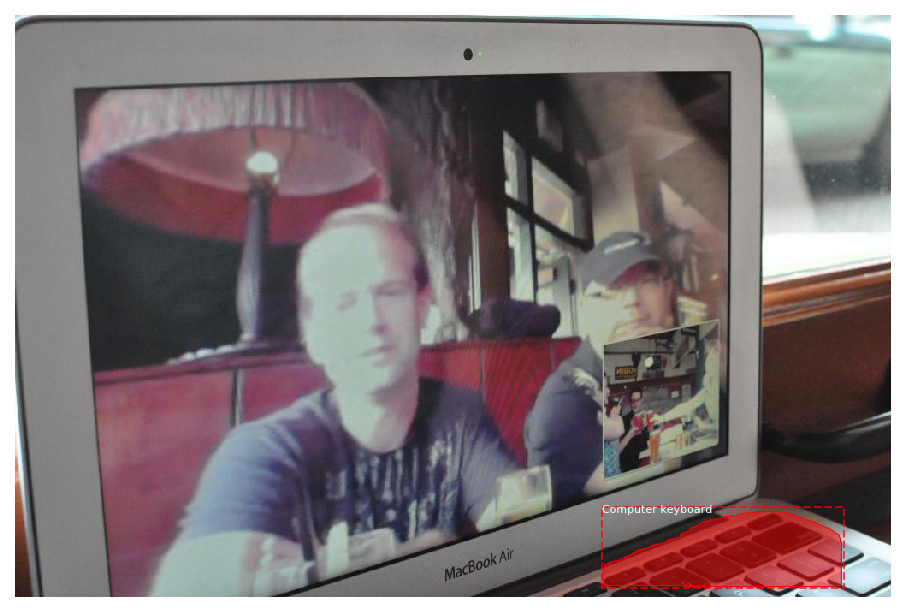

In [182]:
image = dataset_val.load_image(image_id)
visualize.display_instances(image, true_bbox[None, :],true_mask[:,:, None], r['class_ids'], dataset_val.class_names)